# Chapter 5

In [27]:
import os
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats
from theano import shared
import seaborn as sns

In [2]:
%config Inline.figure_format = 'retina'
az.style.use('arviz-darkgrid')
np.random.seed(0)

In [3]:
# Load data
data = pd.read_csv(os.path.join("Data", "WaffleDivorce.csv"), delimiter=";")

In [4]:
data.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [5]:
def standardize(series):
    """Standardize a pandas series"""
    std_series = (series - series.mean()) / series.std()
    return std_series

def unstandardize(std_series, original_series):
    """Given an input series restandardize"""
    unstandardize = std_series*original_series.std() + original_series.mean()
    return unstandardize

#### Code 5.1

In [6]:
# Standard regressors and target
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

#### Code 5.2

In [7]:
data["MedianAgeMarriage"].std()

1.2436303013880823

#### Code 5.3

In [8]:
with pm.Model() as divorce_model_age:
    a = pm.Normal("a", 0, .2)
    bA = pm.Normal("bA", 0, .5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a+bA*data["MedianAgeMarriage_std"])

    divorce_rate_std = pm.Normal("divorce_rate_std", mu=mu, sd=sigma, observed = data["Divorce_std"].values)
    prior_samples = pm.sample_prior_predictive()
    trace_divorce_age = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 5010.74draws/s]


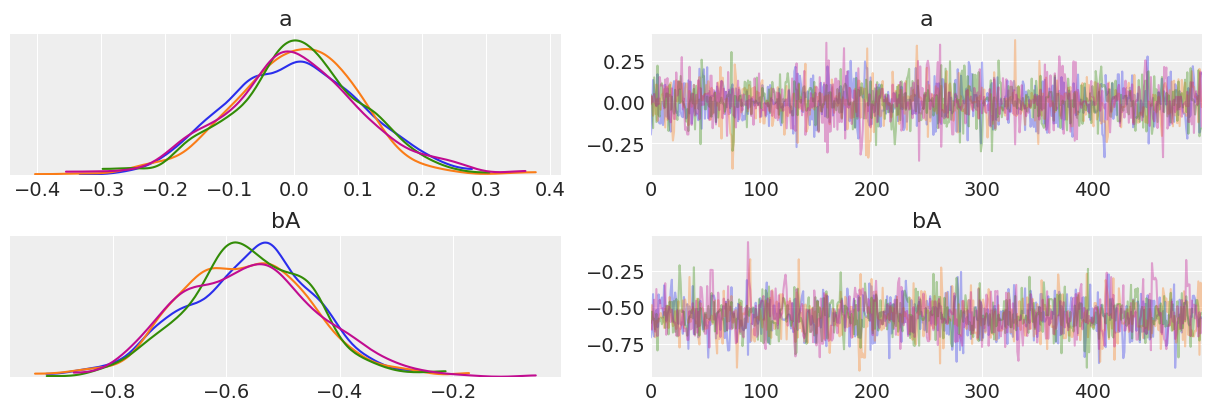

In [9]:
az.plot_trace(trace_divorce_age, var_names = ["a", "bA"]);

#### Code 5.4

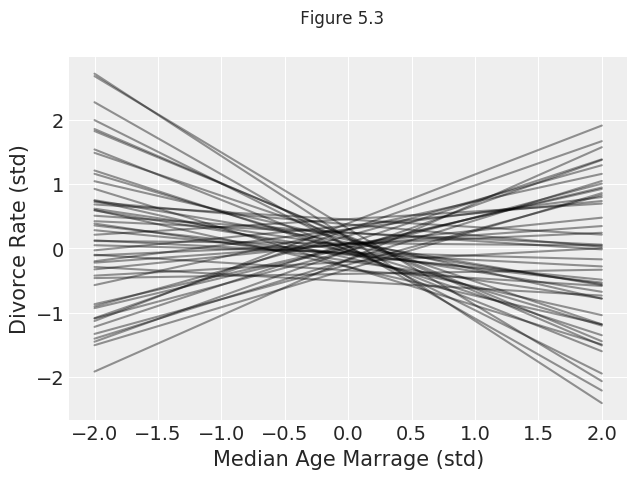

In [10]:
fig, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

for a, ba in zip(prior_samples["a"][:50], prior_samples["bA"][:50]):
    y = a + ba*x 
    ax.plot(x, y, c="black", alpha=.4)
    
ax.set_xlabel("Median Age Marrage (std)")
ax.set_ylabel("Divorce Rate (std)")
fig.suptitle(" Figure 5.3");

#### Code 5.5

In [11]:
trace_divorce_age["bA"].shape

(2000,)

In [12]:
# This is equivalent of link function

age_std_seq = np.linspace(-3, 3.2, 30)

# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
trace_divorce_age_thinned = trace_divorce_age[::10]
mu_pred = np.zeros((len(age_std_seq), len(trace_divorce_age_thinned) * trace_divorce_age_thinned.nchains))

for i, age_std in enumerate(age_std_seq):
    mu_pred[i] = trace_divorce_age_thinned["a"] + trace_divorce_age_thinned["bA"]*age_std

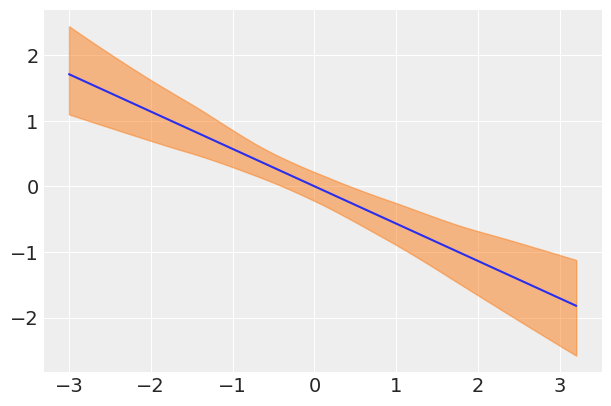

In [13]:
# Now I need to take average of mu and plot
# I should get 30 averages, one for each x
mu_mean = mu_pred.mean(axis=1)
plt.plot(age_std_seq, mu_mean)

# This is equivalent of Percent Interval
az.plot_hpd(age_std_seq, mu_pred.T);

#### 5.6

In [14]:
with pm.Model() as divorce_model_marriage:
    a = pm.Normal("a", 0, .2)
    bM = pm.Normal("bM", 0, .5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a+bM*data["Marriage_std"])

    divorce_rate_std = pm.Normal("divorce_rate_std", mu=mu, sd=sigma, observed = data["Divorce_std"].values)
    prior_samples = pm.sample_prior_predictive()
    trace_divorce_marriage = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 4643.99draws/s]


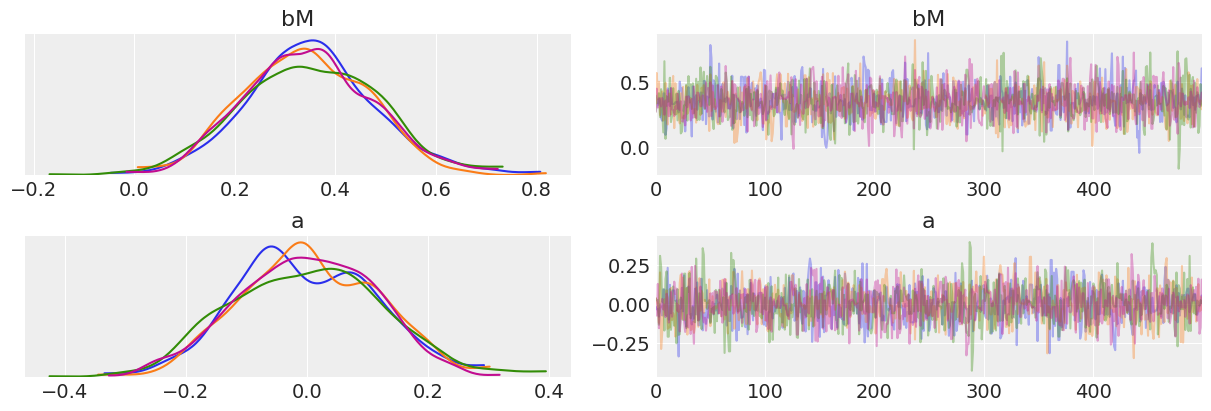

In [15]:
az.plot_trace(trace_divorce_marriage, var_names=["bM", "a"]);

#### 5.7

#### 5.8

#### 5.9

#### 5.13

In [16]:
with pm.Model() as divorce_model_marriage_age:
    a = pm.Normal("a", 0, .2)
    bA = pm.Normal("bA", 0, .5)
    bM = pm.Normal("bM", 0, .5)

    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a+bM*data["Marriage_std"] + bA*data["MedianAgeMarriage_std"])

    divorce_rate_std = pm.Normal("divorce_rate_std", mu=mu, sd=sigma, observed = data["Divorce_std"].values)
    prior_samples = pm.sample_prior_predictive()
    trace_divorce_marriage_age = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, bA, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 3297.39draws/s]


In [17]:
pm.summary(trace_divorce_marriage_age, var_names=["a", "bM", "bA", "sigma"])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.001,0.100,-0.193,0.176,0.002,0.002,1763.0,1056.0,1774.0,1452.0,1.0
bM,-0.063,0.158,-0.367,0.229,0.004,0.004,1540.0,939.0,1538.0,1578.0,1.0
bA,-0.608,0.157,-0.904,-0.317,0.004,0.003,1522.0,1522.0,1529.0,1399.0,1.0
sigma,0.826,0.088,0.672,0.990,0.002,0.002,1600.0,1556.0,1653.0,1352.0,1.0


#### 5.11

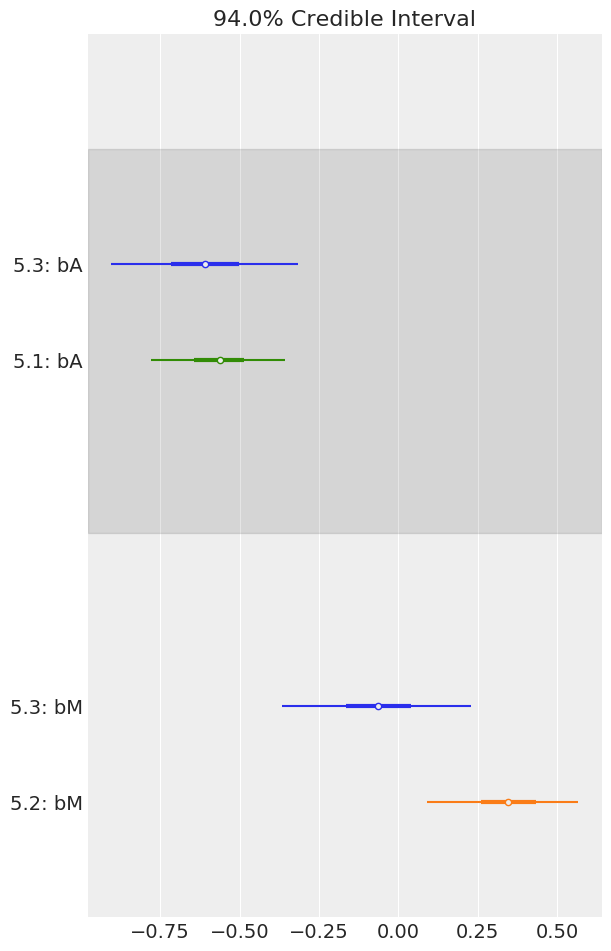

In [18]:
pm.plot_forest([trace_divorce_marriage_age, trace_divorce_marriage, trace_divorce_age,], model_names=["5.3", "5.2", "5.1"], var_names=["bA", "bM"], combined=True);

#### 5.12

In [19]:
N = 50
age = stats.norm().rvs(N)
mar = stats.norm(-age).rvs(N)
div = stats.norm(age).rvs(N)

#### 5.13

In [20]:
 with pm.Model() as model_marriage_age:
    a = pm.Normal("a", 0, .2)
    bAM = pm.Normal("bAM", 0, .5)
    sigma = pm.Exponential("sigma", 1)
    
    mu = pm.Deterministic("mu", a+bAM*data["MedianAgeMarriage_std"])

    marriage_std = pm.Normal("_std", mu=mu, sd=sigma, observed = data["Marriage_std"].values)
    prior_samples = pm.sample_prior_predictive()
    trace_marriage_age = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bAM, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 4585.46draws/s]


#### 5.14

In [21]:
mu_pred_marriage_mean = trace_marriage_age["mu"].mean(axis=0)
residuals = data["Marriage_std"] - mu_pred_marriage_mean

#### 5.15
Something is worng iwth tis plot

In [22]:
# Get mean of trace
mu_pred_divorce_marriage_age = trace_divorce_marriage_age["mu"].mean(axis=0)

In [23]:
# We can skip most of the code with the posterior predictive plot functionality in pymc3
with divorce_model_marriage_age:
    ppc_marriage_age = pm.sample_posterior_predictive(trace_divorce_marriage_age, samples=1000)

mean_posterior_predictive = ppc_marriage_age['divorce_rate_std'].mean(axis=0)

# percentiles = np.percentile(ppc_marriage_age['divorce_rate_std'], [5.5, 94.5], axis=1)
mu_hpd = az.hpd(ppc_marriage_age['divorce_rate_std'], credible_interval=0.89)

/home/canyon/miniconda3/lib/python3.7/site-packages/pymc3/sampling.py:1134: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn("samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:00<00:00, 1323.69it/s]


#### 5.16

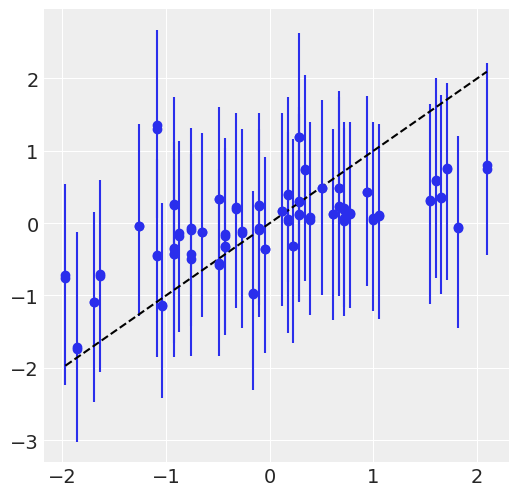

In [24]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(data["Divorce_std"].values, mu_pred_divorce_marriage_age)
plt.errorbar(data["Divorce_std"].values, mean_posterior_predictive, yerr=np.abs(mean_posterior_predictive - mu_hpd.T) , fmt='C0o')

min_x, max_x = data["Divorce_std"].min(), data["Divorce_std"].max()
plt.plot([min_x, max_x], [min_x, max_x], 'k--');


#### 5.18

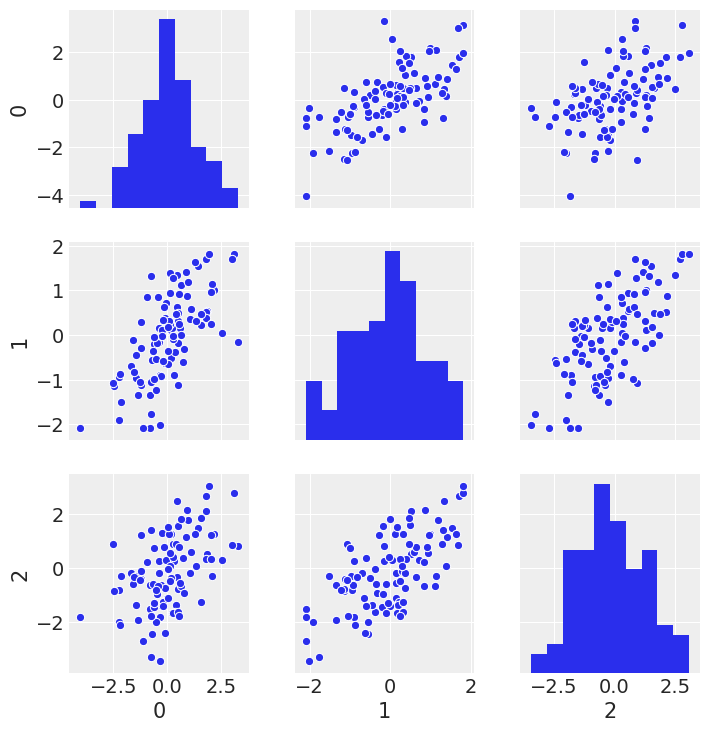

In [28]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(x_real)
y = stats.norm.rvs(x_real)
d = pd.DataFrame([y, x_real, x_spur]).T

sns.pairplot(d);

#### 5.19

In [39]:
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

# Use Theano shared variables so we can change them later
marriage_shared = shared(data["Marriage_std"].values)
age_shared = shared(data["MedianAgeMarriage_std"].values)

with pm.Model() as m5_3_A:
    # A -> D <- M
    sigma = pm.Exponential("sigma", 1)
    bA = pm.Normal("bA", 0, .5)
    bM = pm.Normal("bM", 0, .5)

    a = pm.Normal("a", 0, .2)
    mu = pm.Deterministic("mu", a + bA*age_shared + bM*marriage_shared)
    divorce = pm.Normal("divorce", mu, sigma, observed=data["Divorce_std"])
    
    m5_3_A_divorce_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, bA, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 3997.83draws/s]


In [30]:
# Making this a shared variable lets us manipulate it later

with pm.Model() as m5_3_A_M:
   
    # A -> M
    sigma_M = pm.Exponential("sigma_m", 1)
    bAM = pm.Normal("bAM", 0, .5)
    aM = pm.Normal("aM", 0, .2)
    mu_M = pm.Deterministic("mu_m", aM + bAM*age_shared)
    marriage = pm.Normal("marriage", mu_M, sigma_M, observed=data["Marriage_std"])
    
    m5_3_M_marriage_trace = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aM, bAM, sigma_m]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 4540.49draws/s]


#### 5.20

In [31]:
A_seq = np.linspace(-2, 2, 30)
A_seq.shape

(30,)

#### 5.21
No idea how to do counterfactual correctly

In [37]:
# With PyMC3 we have to simulate in each model separately

# Simulate the marriage rates at each age first
age_shared.set_value(A_seq)

with m5_3_A_M:
    m5_3_M_marriage = pm.sample_posterior_predictive(m5_3_M_marriage_trace, samples=1)
    
marriage_shared.set_values(m5_3_M_marriage["marriage"].values)


/home/canyon/miniconda3/lib/python3.7/site-packages/pymc3/sampling.py:1134: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn("samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1/1 [00:00<00:00, 324.49it/s]


AttributeError: 'TensorSharedVariable' object has no attribute 'set_values'

#### 5.22?

#### 5.23?

#### 5.24?

In [40]:
# Set values for marriage counterfactual
marriage_counter_factual_x = np.linspace(-2, 2, 30)
marriage_shared.set_value(marriage_counter_factual_x)

# Fix age to zero
age_shared.set_value(np.zeros(30))

with m5_3_A:
    marriage_divorce_counterfactual_ppc = pm.sample_posterior_predictive(m5_3_A_divorce_trace)


100%|██████████| 2000/2000 [00:02<00:00, 681.78it/s]


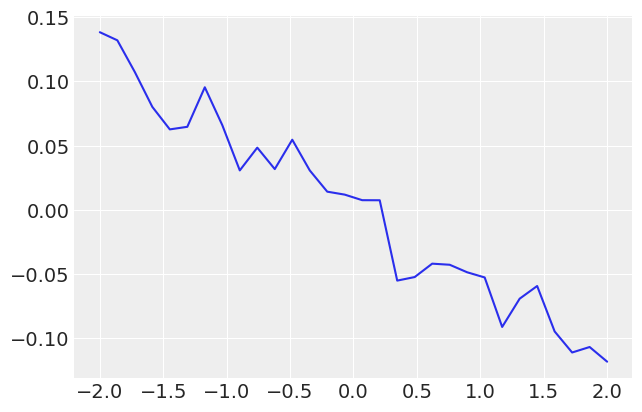

In [41]:
fig, ax = plt.subplots()
divorce_means = marriage_divorce_counterfactual_ppc["divorce"].mean(axis=0)

ax.plot(marriage_counter_factual_x, divorce_means)

#### 5.25

In [42]:
A_seq = np.linspace(-2, 2, 30)

#### 5.26

In [48]:
# Get the samples from Age Marriage model first
with m5_3_A_M:
    m5_3_M_marriage = pm.sample_posterior_predictive(m5_3_M_marriage_trace, var_names=["sigma_m", "aM", "bAM"], samples=1000)
    

/home/canyon/miniconda3/lib/python3.7/site-packages/pymc3/sampling.py:1134: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn("samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:00<00:00, 43849.16it/s]


In [49]:
#marriage_mu_counterfactual = m5_3_M_marriage["aM"] + m5_3_M_marriage["bAM"] 
marriage_mu_counterfactual = np.outer(m5_3_M_marriage["aM"] + m5_3_M_marriage["bAM"], A_seq)
marriage_mu_counterfactual.shape

(1000, 30)

In [50]:
M_sim = stats.norm(loc=marriage_mu_counterfactual.T, scale=m5_3_M_marriage["sigma_m"]).rvs()
M_sim.shape

(30, 1000)

#### 5.27

In [51]:
with m5_3_A:
    m5_3_M_divorce = pm.sample_posterior_predictive(m5_3_A_divorce_trace, var_names=["sigma", "bM", "bA", "a"], samples=1000)

/home/canyon/miniconda3/lib/python3.7/site-packages/pymc3/sampling.py:1134: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn("samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:00<00:00, 34382.36it/s]


In [52]:
D_sim = np.zeros((30, 1000))
a, bM, bA = m5_3_M_divorce["a"], m5_3_M_divorce["bM"], m5_3_M_divorce["bA"]

for i, age_counterfactual in enumerate(A_seq):
    divorce_mu_counterfactual = a + bA*age_counterfactual + bM*M_sim[i,:]
    samples = stats.norm(divorce_mu_counterfactual, m5_3_M_divorce["sigma"]).rvs()
    D_sim[i,:] = samples


#### 5.28

In [ ]:
d = pd.read_csv(os.path.join("Data", "milk.csv"), delimiter=";")
d.head()

#### 5.29

In [99]:
d["K"] = standardize(d["kcal.per.g"])
d["N"] = standardize(d["neocortex.perc"])
d["M"] = standardize(d["mass"])

#### 5.30

In [100]:
with pm.Model() as m5_5_draft:
    # A -> D <- M
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 1)
    a = pm.Normal("a", 0, 1)
    mu = pm.Deterministic("mu", a + bN*d["N"])
    
    K = pm.Normal("K", mu, sigma, observed=d["K"])
    
    m5_5_draft_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bN, sigma]
Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]/home/canyon/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
INFO (theano.gof.compilelock): Waiting for existing lock by unknown process (I am process '31214')
INFO (theano.gof.compilelock): Waiting for existing lock by process '31211' (I am process '31212')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/canyon/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.4-64/lock_dir
INFO (theano.gof.compilelock): To manually release the lock, delete /home/canyon/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.4-64/lock_dir
/home/canyon/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWa

ParallelSamplingError: Bad initial energy

/home/canyon/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


#### 5.32

In [101]:
d["neocortex.perc"]

0     55.16
1       NaN
2       NaN
3       NaN
4       NaN
5     64.54
6     64.54
7     67.64
8       NaN
9     68.85
10    58.85
11    61.69
12    60.32
13      NaN
14      NaN
15    69.97
16      NaN
17    70.41
18      NaN
19    73.40
20      NaN
21    67.53
22      NaN
23    71.26
24    72.60
25      NaN
26    70.24
27    76.30
28    75.49
Name: neocortex.perc, dtype: float64

#### 5.32

In [102]:
dcc = d.dropna(axis=0)
dcc.shape

(17, 11)

#### 5.33

In [103]:
shared_N = shared(dcc["N"].values)

with pm.Model() as m5_5_draft:
    # A -> D <- M
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 1)
    a = pm.Normal("a", 0, 1)
    mu = pm.Deterministic("mu", a + bN*shared_N)
    
    K = pm.Normal("K", mu, sigma, observed=dcc["K"])
    
    m5_5_draft_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bN, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 4599.36draws/s]


#### Bonus: Recreate Figure 5.6 

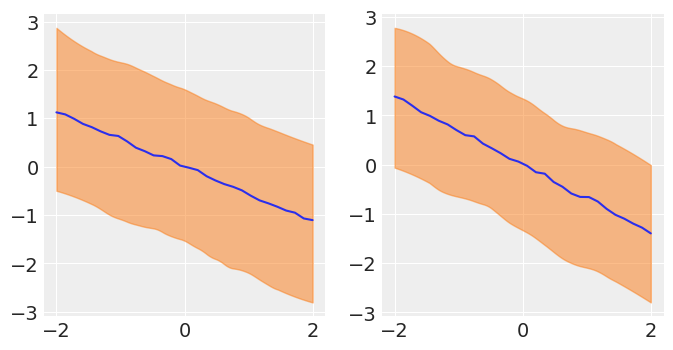

In [104]:
fig, axes = plt.subplots(1,2, figsize=(8,4))
axes[1].plot(A_seq, M_sim.mean(1))
az.plot_hpd(A_seq, M_sim.T, ax=axes[1])

axes[0].plot(A_seq, D_sim.mean(1))
az.plot_hpd(A_seq, D_sim.T, ax=axes[0])

#### 5.34

In [105]:
xseq = [-2,2]
shared_N.set_value(np.array(xseq))
with m5_5_draft:
    m5_5_draft_prior_predictive = pm.sample_prior_predictive()


(-2, 2)

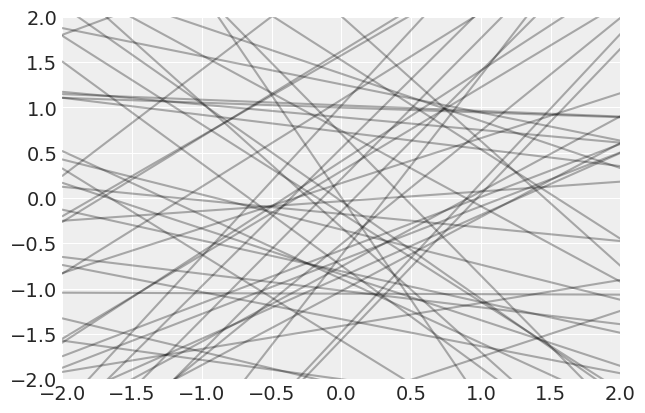

In [106]:
fig, ax = plt.subplots()

for i in range(50):
    ax.plot(xseq,m5_5_draft_prior_predictive["K"][i], c="black", alpha=.3 )
ax.set_xlim(xseq)
ax.set_ylim(xseq)

#### 5.35

In [116]:
shared_N = shared(dcc["N"].values)

with pm.Model() as m5_5:
    # A -> D <- M
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, .5)
    a = pm.Normal("a", 0, .2)
    mu = pm.Deterministic("mu", a + bN*shared_N)
    
    K = pm.Normal("K", mu, sigma, observed=dcc["K"])
    
    m5_5_trace = pm.sample()

m5_5_data = az.from_pymc3(m5_5_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bN, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 5159.72draws/s]
The acceptance probability does not match the target. It is 0.8820445556968689, but should be close to 0.8. Try to increase the number of tuning steps.


#### 5.36

In [108]:
az.summary(m5_5_trace, var_names = ["a", "bN", "sigma"])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.029,0.164,-0.290,0.315,0.003,0.004,2571.0,1037.0,2590.0,1495.0,1.0
bN,0.124,0.253,-0.322,0.603,0.006,0.005,1911.0,1342.0,1947.0,1233.0,1.0
sigma,1.109,0.205,0.746,1.479,0.005,0.004,1732.0,1516.0,1937.0,1356.0,1.0


#### 5.37

100%|██████████| 4000/4000 [00:00<00:00, 5543.54it/s]


(-1.5, 2.2)

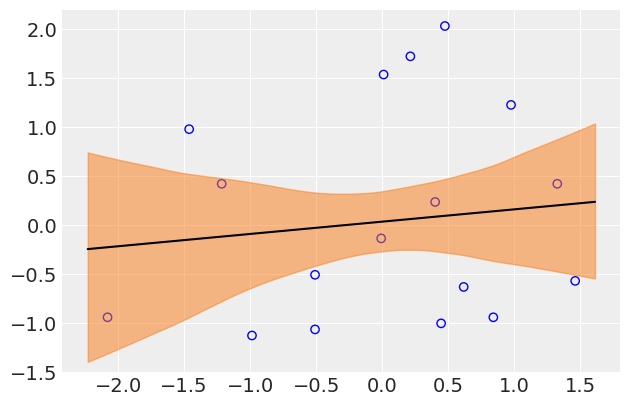

In [118]:
xseq = np.linspace(dcc["N"].min() - .15, dcc["N"].max() + .15, 30)

shared_N.set_value(xseq)

with m5_5:
    m5_5_posterior_predictive = pm.sample_posterior_predictive(m5_5_trace, var_names=["mu"], samples=4000)

mu_mean = m5_5_posterior_predictive["mu"].mean(axis=0)

fig, ax = plt.subplots()
ax.plot(xseq, mu_mean, c="black")
ax.scatter(dcc["N"], dcc["K"], facecolors='none', edgecolors='b') 
az.plot_hpd(xseq, m5_5_posterior_predictive["mu"], ax=ax)
ax.set_ylim(-1.5, 2.2)

#### 5.38

In [110]:
shared_M = shared(dcc["M"].values)

with pm.Model() as m5_6:
    # A -> D <- M
    sigma = pm.Exponential("sigma", 1)
    bM = pm.Normal("bM", 0, .5)
    a = pm.Normal("a", 0, .2)
    mu = pm.Deterministic("mu", a + bM*shared_M)
    
    K = pm.Normal("K", mu, sigma, observed=dcc["K"])
    
    m5_6_trace = pm.sample()
    
m5_6_data = az.from_pymc3(m5_6_trace)
az.summary(m5_6_trace, var_names=["bM", "a", "sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 4990.67draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bM,-0.313,0.240,-0.754,0.173,0.005,0.004,2023.0,1690.0,2028.0,1450.0,1.0
a,0.052,0.162,-0.268,0.335,0.004,0.004,2017.0,982.0,2027.0,1255.0,1.0
sigma,1.057,0.196,0.726,1.428,0.005,0.003,1679.0,1594.0,1793.0,1133.0,1.0


#### 5.39
Why dont these values match the book?

In [125]:
shared_N = shared(dcc["N"].values)
shared_M = shared(dcc["M"].values)

with pm.Model() as m5_7:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, .5)
    bM = pm.Normal("bM", 0, .5)
    a = pm.Normal("a", 0, .2)
    
    mu = pm.Deterministic("mu", a + bN*shared_N + bM*shared_M)
    
    K = pm.Normal("K", mu, sigma, observed=dcc["K"])
    
    m5_7_trace = pm.sample(tune=2000)
    
m5_7_data = az.from_pymc3(m5_7_trace)
az.summary(m5_7_trace, var_names=[ "a","bN","bM","sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, bN, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:02<00:00, 4449.95draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.057,0.157,-0.221,0.363,0.004,0.003,1525.0,1276.0,1572.0,1179.0,1.0
bN,0.374,0.269,-0.156,0.859,0.008,0.005,1232.0,1232.0,1265.0,1293.0,1.0
bM,-0.511,0.274,-1.034,-0.011,0.008,0.005,1283.0,1283.0,1311.0,1173.0,1.0
sigma,0.974,0.196,0.655,1.333,0.005,0.004,1278.0,1254.0,1343.0,1088.0,1.0


#### 5.40

(<Figure size 600x940 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f79f6a9d5d0>],
       dtype=object))

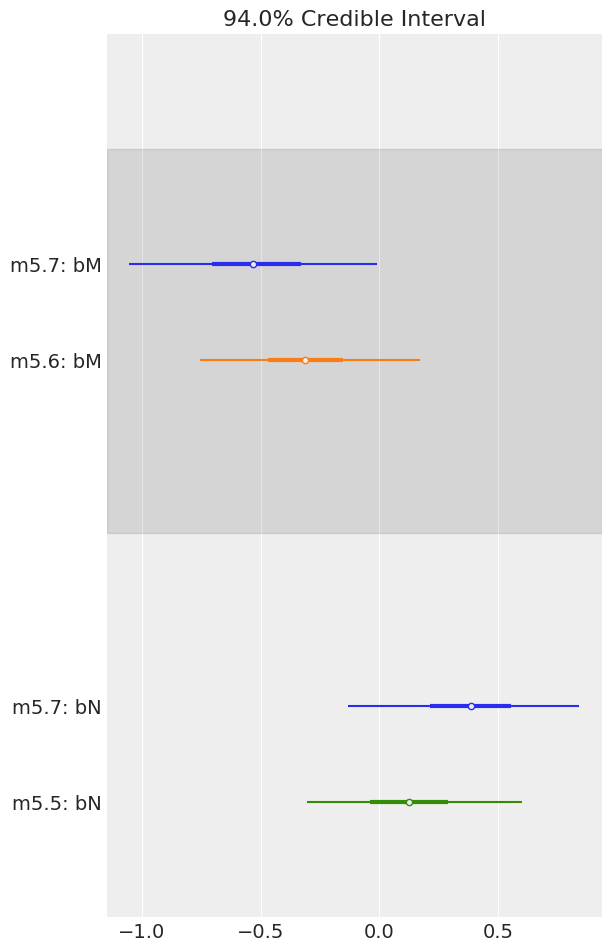

In [120]:
az.plot_forest([m5_7_data, m5_6_data, m5_5_data], model_names=["m5.7", "m5.6", "m5.5"], var_names=["bM", "bN"], combined=True)

#### 5.41?
Why is the plot different than the book?

100%|██████████| 4000/4000 [00:00<00:00, 4667.30it/s]


(-1.5, 2.2)

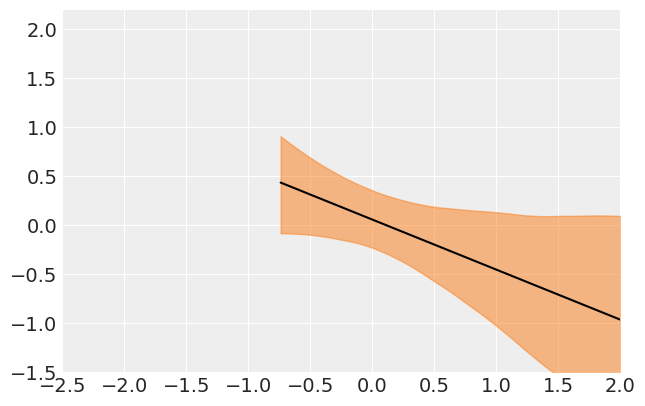

In [129]:
xseq = np.linspace([dcc["M"].min()] - .15, dcc["M"].max() + .15, 30)
shared_N.set_value(np.zeros(30))
shared_M.set_value(xseq)


with m5_7:
    m5_7_posterior_predictive = pm.sample_posterior_predictive(m5_7_trace, var_names=["mu"], samples=4000)

mu_mean = m5_7_posterior_predictive["mu"].mean(axis=0)

fig, ax = plt.subplots()
ax.plot(xseq, mu_mean, c="black")
az.plot_hpd(xseq, m5_7_posterior_predictive["mu"], ax=ax)
ax.set_xlim(-2.5, 2)

ax.set_ylim(-1.5, 2.2)


#### 5.42

In [133]:
# M -> K <- N
# M -> N

n = 100
M = stats.norm().rvs(n)
N = stats.norm(M).rvs(n)
K = stats.norm(N-M).rvs(n)
d_sim = pd.DataFrame({"K":K, "M":M, "N":N})

#### 5.43

In [134]:
# M -> K <- N
# N -> M

n = 100
N = stats.norm().rvs(n)
M = stats.norm(N).rvs(100)
K = stats.norm(N-M).rvs(100)
d_sim2 = pd.DataFrame({"K":K, "M":M, "N":N})

# M -> K <- N
# M <- U -> N

n = 100
U = stats.norm().rvs(n)
N = stats.norm(U).rvs(n)
M = stats.norm(U).rvs(100)
K = stats.norm(N-M).rvs(100)
d_sim3 = pd.DataFrame({"K":K, "M":M, "N":N})

## Extra code
Code that recreates some of the figures whos code isnt included in the book

In [113]:
# Change domain of vars back to domain of original units
regular_age_seq = unstandardize(age_std_seq, data["MedianAgeMarriage"])
regular_divorce_seq = unstandardize(mu_mean, data["Divorce"])
regular_divorce_seq_pred = unstandardize(mu_pred, data["Divorce"])

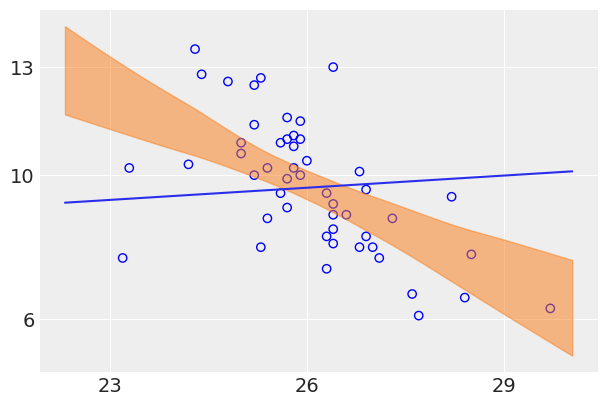

In [114]:
fig, ax = plt.subplots()

ax.scatter(data["MedianAgeMarriage"], data["Divorce"], facecolors='none', edgecolors='b')
ax.set_yticks([13, 10, 6])
ax.set_xticks([23, 26, 29])
ax.plot(regular_age_seq, regular_divorce_seq)
az.plot_hpd(regular_age_seq, regular_divorce_seq_pred.T)